In [1]:
import pandas as pd
df = pd.read_csv('yelp.csv')

In [2]:
df.head(5)

,rating,review
0,5,I used this app for the first time last Friday...
1,1,"Lost items, slow customer service (only availa..."
2,1,BEYOND TERRIBLE SERVICE. I'm not one to write ...
3,1,This was my first time using Cleanly. I decide...
4,1,Used cleanly again and they lost my entire bag...


In [3]:
import numpy as np
df['rating_type'] = np.where(df['rating']>=3, 'positive', 'negative')

negative=df[df['rating_type']=='negative']
negative.index = range(len(negative.index))
print(negative.shape)
negative=negative[['review']]

(372, 3)


In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Convert to list
data = negative.review.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

['Lost items, slow customer service (only available by email - the phones dont '
 'really work), and its a hassle to get a reimbursement when youre missing '
 'clothes if you get a reimbursement at all. Not worth the steep price.I wont '
 'be using Cleanly again.']
[['lost', 'items', 'slow', 'customer', 'service', 'only', 'available', 'by', 'email', 'the', 'phones', 'dont', 'really', 'work', 'and', 'its', 'hassle', 'to', 'get', 'reimbursement', 'when', 'youre', 'missing', 'clothes', 'if', 'you', 'get', 'reimbursement', 'at', 'all', 'not', 'worth', 'the', 'steep', 'price', 'wont', 'be', 'using', 'cleanly', 'again']]


In [5]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['beyond', 'terrible', 'service', 'im', 'not', 'one', 'to', 'write', 'reviews', 'but', 'felt', 'it', 'necessary', 'this', 'is', 'the', 'th', 'time', 'now', 'ive', 'had', 'an', 'issue', 'with', 'cleanly', 'services', 'not', 'once', 'have', 'they', 'ever', 'accommodated', 'after', 'each', 'issue', 'damage', 'customer', 'service', 'is', 'pathetic', 'ripped', 'and', 'torn', 'items', 'shirts', 'sheets', 'white', 'duvet', 'cover', 'stained', 'dark', 'blue', 'whites', 'stained', 'gray', 'color', 'requested', 'and', 'paid', 'for', 'overnight', 'service', 'and', 'customer', 'service', 'replied', 'day', 'later', 'saying', 'their', 'driver', 'was', 'unable', 'to', 'complete', 'the', 'drop_off', 'and', 'ultimately', 'dropped_off', 'days', 'late', 'still', 'charged', 'for', 'overnight', 'fees', 'most', 'recently', 'received', 'my', 'white', 'curtains', 'heavily', 'stained', 'and', 'ultimately', 'had', 'to', 'throw', 'them', 'out', 'which', 'bought', 'for', 'at', 'this', 'time', 'was', 'leaving', 'o

In [6]:
bigram_mod

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['lose', 'item', 'slow', 'customer', 'service', 'available', 'email', 'phone', 'do', 'not', 'really', 'work', 'hassle', 'get', 'reimbursement', 'be', 'miss', 'clothe', 'get', 'reimbursement', 'worth', 'steep', 'price', 'will', 'not', 'use', 'cleanly']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]]


In [88]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [89]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"not" + 0.021*"service" + 0.018*"cleanly" + 0.017*"time" + '
  '0.017*"laundry" + 0.017*"clothe" + 0.016*"get" + 0.012*"do" + 0.012*"would" '
  '+ 0.011*"lose"'),
 (1,
  '0.023*"service" + 0.015*"lose" + 0.011*"stain" + 0.011*"item" + '
  '0.009*"customer" + 0.008*"shirt" + 0.008*"white" + 0.007*"cleanly" + '
  '0.007*"reimburse" + 0.007*"damage"'),
 (2,
  '0.027*"dry" + 0.023*"clean" + 0.018*"item" + 0.011*"dress" + 0.007*"return" '
  '+ 0.007*"shirt" + 0.007*"would" + 0.006*"company" + 0.006*"good" + '
  '0.006*"send"')]


In [90]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.674329182016727

Coherence Score:  0.3493433347693902


In [10]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path


In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [12]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=12, step=1)


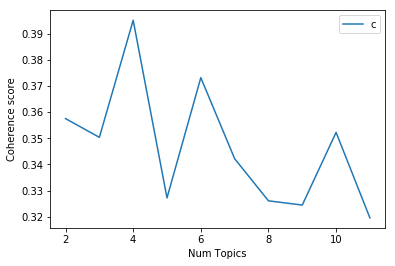

In [13]:
# Show graph
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.166*"service" + 0.094*"customer" + 0.038*"bad" + 0.035*"return" + '
  '0.031*"fold" + 0.023*"offer" + 0.019*"problem" + 0.018*"stain" + '
  '0.016*"give" + 0.013*"smell"'),
 (1,
  '0.077*"order" + 0.051*"email" + 0.050*"call" + 0.042*"deliver" + '
  '0.035*"receive" + 0.022*"phone" + 0.021*"response" + 0.021*"hour" + '
  '0.020*"text" + 0.019*"issue"'),
 (2,
  '0.101*"time" + 0.036*"pick" + 0.034*"drop" + 0.032*"service" + 0.031*"late" '
  '+ 0.027*"wait" + 0.026*"pickup" + 0.025*"app" + 0.023*"reschedule" + '
  '0.019*"schedule"'),
 (3,
  '0.138*"clothe" + 0.136*"laundry" + 0.058*"bag" + 0.042*"give" + '
  '0.037*"cleanly" + 0.031*"charge" + 0.024*"business" + 0.019*"review" + '
  '0.016*"entire" + 0.014*"completely"'),
 (4,
  '0.119*"cleanly" + 0.067*"day" + 0.066*"delivery" + 0.039*"find" + '
  '0.034*"company" + 0.031*"miss" + 0.029*"work" + 0.025*"contact" + '
  '0.021*"credit" + 0.019*"refund"'),
 (5,
  '0.078*"back" + 0.039*"wash" + 0.033*"good" + 0.031*"time" + '
  '0

In [17]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(negative['review'].values)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [18]:
#positive['review'].values

In [40]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=negative)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.1763,"lose, item, clean, dry, shirt, cost, clothing,...","Lost items, slow customer service (only availa..."
1,1,0.0,0.2484,"service, customer, bad, return, fold, offer, p...",BEYOND TERRIBLE SERVICE. I'm not one to write ...
2,2,5.0,0.3761,"back, wash, good, time, experience, thing, mak...",This was my first time using Cleanly. I decide...
3,3,3.0,0.2138,"clothe, laundry, bag, give, cleanly, charge, b...",Used cleanly again and they lost my entire bag...
4,4,0.0,0.2609,"service, customer, bad, return, fold, offer, p...",****Updated review****I've attached 2 screensh...
5,5,3.0,0.1773,"clothe, laundry, bag, give, cleanly, charge, b...",As per previous reviews absolutely horrible cu...
6,6,0.0,0.2030,"service, customer, bad, return, fold, offer, p...",This is the WORST DRYCLEANING SERVICE IN THE H...
7,7,1.0,0.2062,"order, email, call, deliver, receive, phone, r...",Well I'm writing this now in hopes I'll get so...
8,8,0.0,0.1776,"service, customer, bad, return, fold, offer, p...",Cleanly lost $$$ thousands of dollars of desig...
9,9,3.0,0.1810,"clothe, laundry, bag, give, cleanly, charge, b...",My friend warned me against this company when ...


In [99]:
x = pd.DataFrame({'words':data_lemmatized})
x = df_dominant_topic.merge(x,  left_index=True, right_index=True)
x['words'] = x.words.astype(str).str.replace('\[|\]|\'', '')
x.head(1)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,words
0,0,0.0,0.1745,"lose, cleanly, item, clothe, cost, day, busine...","Lost items, slow customer service (only availa...","lose, item, slow, customer, service, available..."


In [138]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(x['Text'][0])
displacy.render(nlp(x['Text'][1]), style='dep', jupyter = True)


In [142]:
from __future__ import unicode_literals
import spacy,en_core_web_sm
import textacy
nlp = en_core_web_sm.load()
sentence = ' '.join([doc for doc in x['Text']])
pattern = r'<ADJ>?<NOUN><NOUN>+ ? '
doc = textacy.Doc(nlp(sentence.lower()), lang='en_core_web_sm')
lists = textacy.extract.pos_regex_matches(doc, pattern)

verb_phrases = [l.text for l in lists]
from collections import Counter
counts = Counter(verb_phrases)
print(counts)

Counter({'customer service': 120, 'their customer service': 26, 'business days': 14, 'people who': 8, 'worst customer service': 7, 'phone number': 7, 'customer support': 7, 'delivery person': 7, 'better business bureau': 7, 'text message': 6, 'phone call': 5, 'reserve membership': 5, 'delivery people': 5, 'cleaning service': 5, 'delivery guy': 5, 'horrible customer service': 4, 'my credit card': 4, 'terrible customer service': 4, 'small claims court': 4, 'delivery window': 4, 'hour window': 4, 'dollars worth': 4, 'dry cleaning order': 4, 'fabric softener': 4, 'full size sheets': 3, 'delivery date': 3, 'gym clothes': 3, 'pick ups': 3, 'dress shirt': 3, 'my delivery window': 3, 'sunday evening': 3, 'sunday night': 3, 'quality control': 3, 'garment bag': 3, 'support team': 3, 'day window': 2, 'washing machine': 2, 'pillow cases': 2, 'bed sheets': 2, 'my workout clothes': 2, 'designer clothes': 2, 'dry cleaning service': 2, 'their delivery service': 2, 'tomorrow morning': 2, 'rush service'

In [ ]:
#x['words'].apply(lambda y: y.replace('[','').replace(']',''))


Topic: 0.0


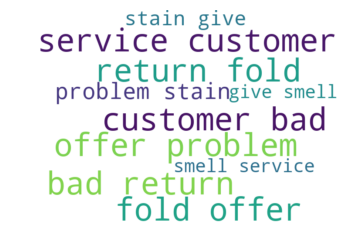

Topic: 1.0


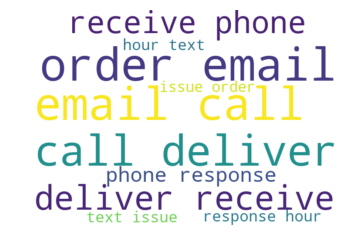

Topic: 2.0


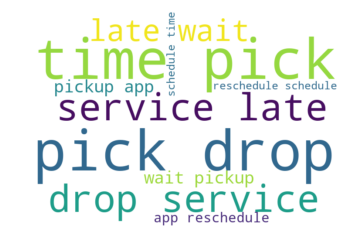

Topic: 3.0


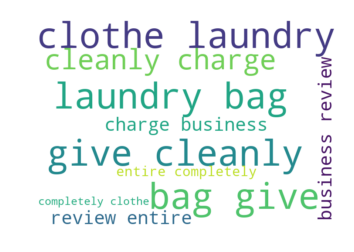

Topic: 4.0


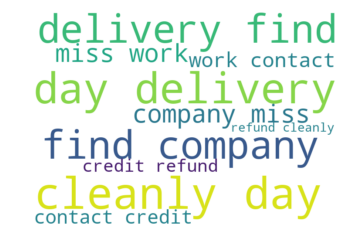

Topic: 5.0


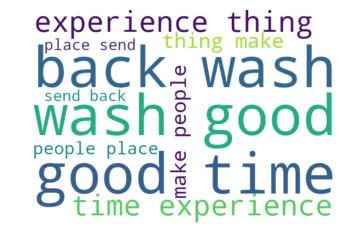

Topic: 6.0


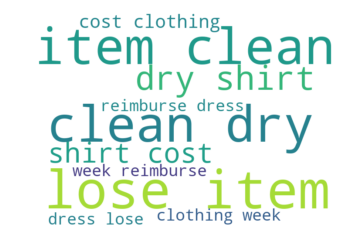

In [129]:
#Topic keys
from wordcloud import WordCloud
import matplotlib.pyplot as plt
Topic_keys = pd.DataFrame(df_dominant_topic['Keywords'].groupby(df_dominant_topic['Dominant_Topic']).apply(list))

Topic_keys['Topic'] = Topic_keys.index
Topic_keys.index=range(len(Topic_keys.index))

for i in range(len(Topic_keys)):
    
    text=' '.join(Topic_keys['Keywords'][i]) 

    wordcloud = WordCloud(width=700, height=500, margin=0, background_color="white").generate(text)

    print('Topic: %s' % (Topic_keys['Topic'][i]))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
  

Text(0.5,0,'Topic_Proportion')

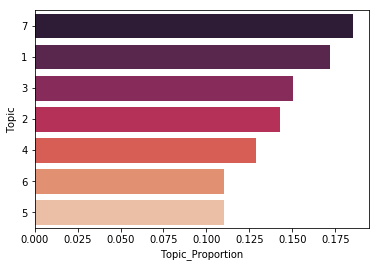

In [124]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Show
topic_prop = pd.DataFrame(topic_contribution)
topic_prop['Topic'] = topic_prop.index
topic_prop['Topic'] = topic_prop['Topic']+1
topic_prop.index = range(len(topic_prop.index))
topic_prop = topic_prop.rename(columns={'Dominant_Topic':'Topic_Proportion'})

#topic_prop.style.format({'Topic_Proportion': "{:.2%}"})
import seaborn as sns
ax = sns.barplot(x='Topic_Proportion', y='Topic', data=topic_prop,  orient = 'h',palette="rocket", order =topic_prop['Topic'] )
ax.set_xlabel('Topic_Proportion')

In [115]:
topic_prop

,Topic_Proportion,Topic
0,0.1855,6
1,0.1720,0
2,0.1505,2
3,0.1425,1
4,0.1290,3
5,0.1102,5
6,0.1102,4


In [99]:
from gensim.models.ldamodel import LdaModel
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
gamma_threshold=0.001,
dtype=np.float32
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim


In [ ]:
def malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50):
 """
 Function to convert mallet model to gensim LdaModel. This works by copying the
 training model weights (alpha, beta...) from a trained mallet model into the
 gensim model.

 Args:
 mallet_model : Trained mallet model
 gamma_threshold : To be used for inference in the new LdaModel.
 iterations : number of iterations to be used for inference in the new LdaModel.

 Returns:
 model_gensim : LdaModel instance; copied gensim LdaModel
 """
 model_gensim = LdaModel(
   id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
   alpha=mallet_model.alpha, iterations=iterations,
   eta=mallet_model.word_topics,
   gamma_threshold=gamma_threshold,
   dtype=numpy.float64 # don't loose precision when converting from MALLET
 )
    model_gensim.expElogbeta[:] = mallet_model.wordtopics
    return model_gensim

In [100]:
lda_model = convertldaGenToldaMallet(optimal_model)

In [101]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x  \
topic             
0      0.094618   
1      0.131051   
2      0.218377   
3     -0.307797   
4     -0.283959   
5      0.151540   
6     -0.003830   

              y  \
topic             
0      0.268681   
1     -0.001842   
2      0.132645   
3      0.095407   
4      0.011236   
5     -0.151441   
6     -0.354686   

       topics  \
topic           
0           1   
1           2   
2           3   
3           4   
4           5   
5           6   
6           7   

       cluster  \
topic            
0            1   
1            1   
2            1   
3            1   
4            1   
5            1   
6            1   

            Freq  
topic             
0      13.662289  
1      15.247769  
2      14.635158  
3      13.936130  
4      14.067997  
5      14.239703  
6      14.210961  , topic_info=     Category  \
17    Default   
3     Default   
173   Default   
2     Default   
10    Default   
9     Default   
4     Default   
80    Default   
296   Default   
91    Default   
141   Default   
37    Default   
101   Default   
293   Default   
139   Default   
6     Default   
248   Default   
370   Default   
107   Default   
133   Default   
167   Default   
73    Default   
214   Default   
60    Default   
297   Default   
39    Default   
68    Default   
218   Default   
614   Default   
29    Default   
...       ...   
231    Topic7   
304    Topic7   
279    Topic7   
861    Topic7   
394    Topic7   
117    Topic7   
158    Topic7   
283    Topic7   
292    Topic7   
121    Topic7   
280    Topic7   
692    Topic7   
483    Topic7   
380    Topic7   
510    Topic7   
610    Topic7   
405    Topic7   
1271   Topic7   
303    Topic7   
16     Topic7   
63     Topic7   
687    Topic7   
127    Topic7   
315    Topic7   
106    Topic7   
240    Topic7   
314    Topic7   
85     Topic7   
23     Topic7   
189    Topic7   

            Freq  \
17    698.000000   
3     491.000000   
173   484.000000   
2     557.000000   
10    380.000000   
9     347.000000   
4     327.000000   
80    503.000000   
296   298.000000   
91    300.000000   
141   252.000000   
37    240.000000   
101   222.000000   
293   256.000000   
139   206.000000   
6     197.000000   
248   194.000000   
370   162.000000   
107   204.000000   
133   142.000000   
167   139.000000   
73    139.000000   
214   131.000000   
60    134.000000   
297   192.000000   
39    126.000000   
68    125.000000   
218   120.000000   
614   119.000000   
29    110.000000   
...          ...   
231    45.248604   
304    42.662971   
279    37.491703   
861    34.906067   
394    31.027617   
117    25.856346   
158    24.563528   
283    23.270712   
292    20.685076   
121    19.392260   
280    18.099442   
692    18.099442   
483    16.806625   
380    16.806625   
510    15.513808   
610    15.513808   
405    15.513808   
1271   15.513808   
303    15.513808   
16     49.127056   
63     37.491703   
687    45.248604   
127    15.513808   
315    25.856346   
106    36.198883   
240    23.270712   
314    77.569038   
85     73.690582   
23     33.613251   
189    24.563528   

               Term  \
17          service   
3            clothe   
173         laundry   
2           cleanly   
10             lose   
9              item   
4          customer   
80             time   
296           order   
91             back   
141           clean   
37              day   
101             dry   
293        delivery   
139             bag   
6             email   
248            call   
370         deliver   
107            give   
133            wash   
167            find   
73            shirt   
214             bad   
60          receive   
297            pick   
39             drop   
68           return   
218         company   
614            good   
29           charge   
...             ...   
231          policy   
304        cleaning   
279          dollar   
861             top   
3

In [47]:
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.save_html(p, 'lda_negative.html')

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [128]:
print(df_topic_sents_keywords[0][88])

Update: cleanly has lost about $300 worth of my delicates. It's been a process trying to have them reimburse me after they admit to their mistake, only to have them tell me they will reimburse me $135 cash for my items. After emailing them several days ago telling them that is unacceptable, they have yet to respond to me. Still waiting for my proper reimbursement that is well within your guidelines, Cleanly. Never using again.


In [126]:
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic']==6]



,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,6,0.1763,"lose, item, clean, dry, shirt, cost, clothing,...","Lost items, slow customer service (only availa..."
10,6,0.2092,"lose, item, clean, dry, shirt, cost, clothing,...",Worst online dry cleaning service I have ever ...
11,6,0.2267,"lose, item, clean, dry, shirt, cost, clothing,...","I am so livid right now, my sister had couple ..."
13,6,0.2589,"lose, item, clean, dry, shirt, cost, clothing,...","Long and short of it, from pick up to cleaning..."
16,6,0.1861,"lose, item, clean, dry, shirt, cost, clothing,...",The worst customer service! The first bad expe...
25,6,0.2263,"lose, item, clean, dry, shirt, cost, clothing,...",I used Cleanly for the first time last week --...
28,6,0.2796,"lose, item, clean, dry, shirt, cost, clothing,...","I've used Cleanly twice, once smoothly without..."
32,6,0.2070,"lose, item, clean, dry, shirt, cost, clothing,...",Quick update for everyone! Cleanly mostly igno...
35,6,0.2448,"lose, item, clean, dry, shirt, cost, clothing,...","After dry cleaning, They staple on their paper..."
37,6,0.2276,"lose, item, clean, dry, shirt, cost, clothing,...",This is one if the worst dry cleaning services...


In [90]:
phi_df = df_dominant_topic.groupby(['Dominant_Topic', 'Keywords'])['Keywords'].count().reset_index(name ='token_count')
phi_df = phi_df.sort_values(by='Dominant_Topic', ascending=True)


phi_df[:10]

,Dominant_Topic,Keywords,token_count
0,0.0,"service, customer, bad, return, fold, offer, p...",64
1,1.0,"order, email, call, deliver, receive, phone, r...",53
2,2.0,"time, pick, drop, service, late, wait, pickup,...",56
3,3.0,"clothe, laundry, bag, give, cleanly, charge, b...",48
4,4.0,"cleanly, day, delivery, find, company, miss, w...",41
5,5.0,"back, wash, good, time, experience, thing, mak...",41
6,6.0,"lose, item, clean, dry, shirt, cost, clothing,...",69


In [91]:
import sklearn.preprocessing
def pivot_and_smooth(df, smooth_value, rows_variable, cols_variable, values_variable):
    """
    Turns the pandas dataframe into a data matrix.
    Args:
        df (dataframe): aggregated dataframe 
        smooth_value (float): value to add to the matrix to account for the priors
        rows_variable (str): name of dataframe column to use as the rows in the matrix
        cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable(str): name of the dataframe column to use as the values in the matrix
    Returns:
        dataframe: pandas matrix that has been normalized on the rows.
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_value
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

phi = pivot_and_smooth(phi_df, beta, 'Dominant_Topic', 'Keywords', 'token_count')

NameError: name 'beta' is not defined

In [130]:
df_dominant_topic[['Dominant_Topic', 'Topic_Perc_Contrib', 'Text']].to_csv('yelp_negative_reviews.csv', index = False)

In [139]:
df_dominant_topic[['Dominant_Topic', 'Topic_Perc_Contrib', 'Text']]['Text'][153]

"Deserves negative stars. AVOID CLEANLY AT ALL COSTS.Our experience with Cleanly has been a completely Kafkaesque nightmare.We gave them a bag of laundry (containing almost all of my girlfriend's clothes) and a good amount of dry cleaning. We were excited to try the service, hoping that it would save us the inconvenience of walking our laundry down the block to do ourselves.Cleanly lost ALL the laundry we gave them, and returned the dry cleaning with severely damaged or lost items. The suit I gave them came back with a 1+ inch hole in the arm. How could that even happen? My girlfriend's Marc Jacobs ski jacket had the fur lining completely lost.We then repeatedly called Cleanly's customer service line, without any answer for days. When we finally started receiving responses to our emails (still no calls), the responses made it feel like losing all of a customer's items was completely routine for them. They refused to tell us anything about whether we would be refunded for the service or

In [138]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.1763,"lose, item, clean, dry, shirt, cost, clothing,...","Lost items, slow customer service (only availa..."
1,1,0.0,0.2484,"service, customer, bad, return, fold, offer, p...",BEYOND TERRIBLE SERVICE. I'm not one to write ...
2,2,5.0,0.3761,"back, wash, good, time, experience, thing, mak...",This was my first time using Cleanly. I decide...
3,3,3.0,0.2138,"clothe, laundry, bag, give, cleanly, charge, b...",Used cleanly again and they lost my entire bag...
4,4,0.0,0.2609,"service, customer, bad, return, fold, offer, p...",****Updated review****I've attached 2 screensh...
5,5,3.0,0.1773,"clothe, laundry, bag, give, cleanly, charge, b...",As per previous reviews absolutely horrible cu...
6,6,0.0,0.2030,"service, customer, bad, return, fold, offer, p...",This is the WORST DRYCLEANING SERVICE IN THE H...
7,7,1.0,0.2062,"order, email, call, deliver, receive, phone, r...",Well I'm writing this now in hopes I'll get so...
8,8,0.0,0.1776,"service, customer, bad, return, fold, offer, p...",Cleanly lost $$$ thousands of dollars of desig...
9,9,3.0,0.1810,"clothe, laundry, bag, give, cleanly, charge, b...",My friend warned me against this company when ...
